Explore results of nn

In [4]:
import theano
import numpy

from theano import tensor
from fuel.streams import ServerDataStream
import sys
sys.path.append('../models/')
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from models. import build_model
from blocks.algorithms import GradientDescent, Adam
from blocks.graph import ComputationGraph
from blocks.model import Model
from blocks.serialization import load_parameters, load
import pickle

In [5]:
images           = tensor.dtensor4('images')
images_test      = tensor.dtensor4('images_test')
labels           = tensor.lmatrix('labels')
cost             = build_model(images.dimshuffle(0,3,1,2), labels)

In [6]:
dict = {0: 'safe driving', 1: 'texting-right', 2: 'talking on the phone - right', 3: 'texting - left',
           4: 'talking on the phone', 5: 'operating the radio', 6: 'drinking', 7: 'reaching behind',
           8: 'hair and makeup', 9: 'talking to passenger'}

Upload nn and parameters

In [8]:
parameters = load_parameters(open("../../train", "rb"))
model = Model(cost)
model.set_parameter_values(parameters)
sample = theano.function([images_test], model.get_top_bricks()[0].apply(images_test.dimshuffle(0,3,1,2)))

Upload testing data

In [26]:
from fuel.datasets.hdf5 import H5PYDataset
from fuel.schemes import SequentialScheme, ShuffledScheme
from fuel.streams import DataStream
sys.path.append('../functions/')
from custom_transformers import Normalize, Cast
submit_set = H5PYDataset('../../data/data.hdf5', which_sets=('submit',), subset=slice(0, 79726),)

In [45]:
submit_stream = DataStream.default_stream(
    submit_set,
    iteration_scheme=SequentialScheme(submit_set.num_examples, 500)
)
submit_stream_normalized = Normalize(submit_stream)
submit_stream_casted     = Cast(submit_stream_normalized, 'floatX')
submit_it   = submit_stream_casted.get_epoch_iterator()

Plot images and predicted label

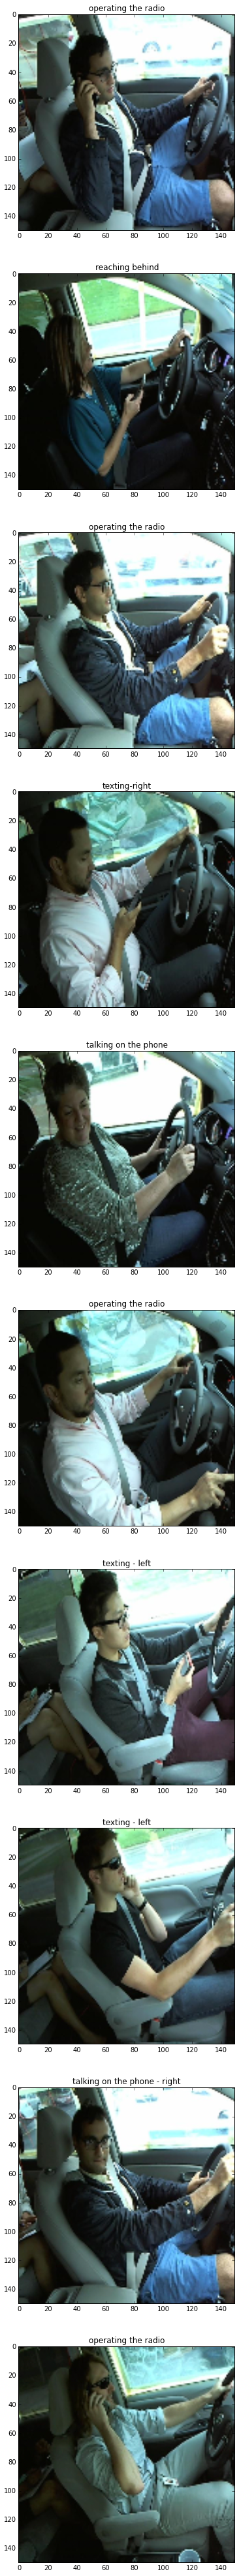

In [50]:
submit_data = submit_it.next()
submit_labels = sample(submit_data[0])
plt.figure(figsize=(30,70))
for i in range(10):
    plt.subplot(10, 1, i)
    plt.imshow(submit_data[0][i][:,:,::-1])
    plt.title(dict[numpy.argmax(submit_labels,axis=1)[i]])

Upload validation data

In [42]:
valid_set = H5PYDataset('../../data/data.hdf5', which_sets=('train',), subset=slice(20000, 22424),)
valid_stream = DataStream.default_stream(
    valid_set,
    iteration_scheme=ShuffledScheme(valid_set.num_examples, 500)
)
valid_stream_normalized = Normalize(valid_stream)
valid_stream_casted     = Cast(valid_stream_normalized, 'floatX')
valid_it                = valid_stream_casted.get_epoch_iterator()

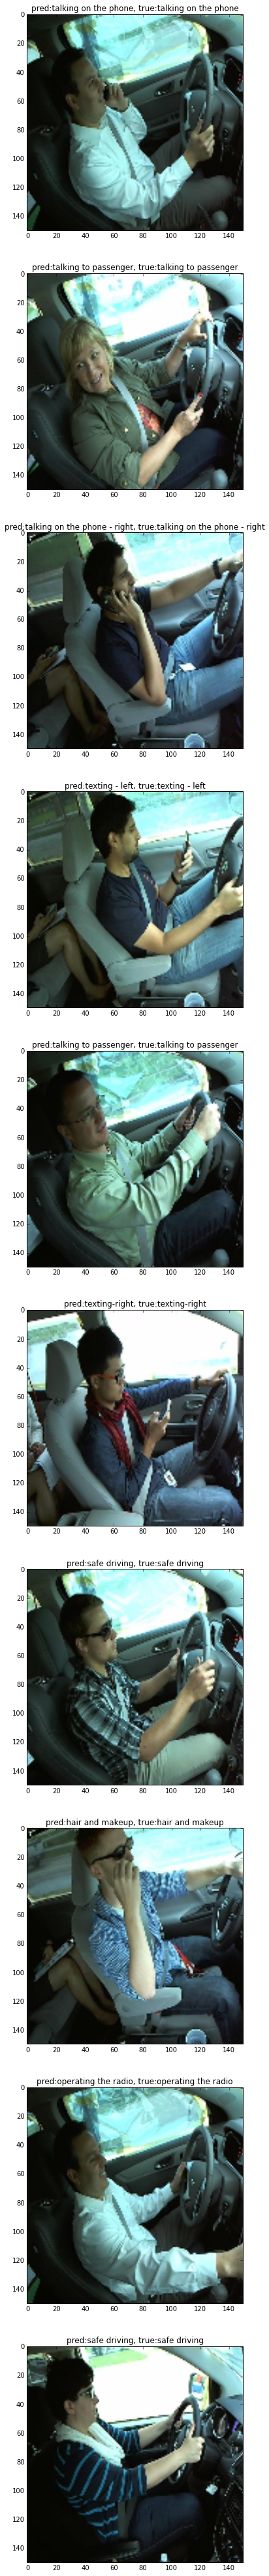

In [49]:
valid_stream.reset()
valid_data = valid_it.next()
valid_labels = sample(valid_data[0])
plt.figure(figsize=(30,70))
for i in range(10):
    plt.subplot(10, 1, i)
    plt.imshow(valid_data[0][i][:,:,::-1])
    plt.title('pred:' + dict[numpy.argmax(valid_labels,axis=1)[i]] +', true:' + dict[valid_data[1][i][0]])